In [111]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy import stats
from sklearn.linear_model import LinearRegression

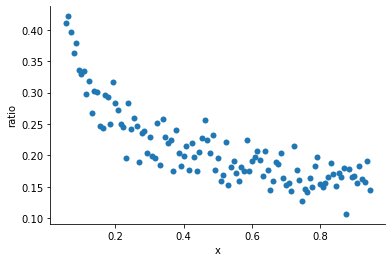

In [9]:
## Check sample data from Haller & Messer 2017 (https://github.com/MesserLab/asymptoticMK/tree/master)
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/Extensions_MKT/'
file_name = 'sample_polymorphism_levels.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t') 
df['ratio'] = df['pN'] / df['pS']

# sns.scatterplot(data=df, x='x', y='pN', linewidth=0)
# sns.scatterplot(data=df, x='x', y='pS', linewidth=0)
sns.scatterplot(data=df, x='x', y='ratio', linewidth=0)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


[31  9 12  5  1]
[0.016  0.1516 0.2872 0.4228 0.5584 0.694 ]
[66 22 11 23 11]
[0.016  0.1096 0.2032 0.2968 0.3904 0.484 ]


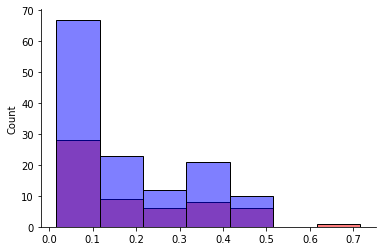

In [143]:
pN = '0.017,0.048,0.016,0.016,0.016,0.435,0.113,0.032,0.403,0.016,0.5,0.645,0.016,0.016,0.032,0.016,0.065,0.081,0.016,0.435,0.048,0.097,0.355,0.016,0.613,0.613,0.017,0.016,0.016,0.032'
pS = '0.177,0.016,0.081,0.145,0.145,0.016,0.968,0.016,0.032,0.016,0.065,0.016,0.016,0.129,0.016,0.081,0.016,0.081,0.016,0.161'

pN = '0.016,0.016,0.371,0.032,0.129,0.016,0.113,0.183,0.354,0.032,0.032,0.339,0.323,0.355,0.367,0.383,0.35,0.31,0.31,0.259,0.233,0.468,0.484,0.484,0.484,0.016,0.048,0.29,0.419,0.435,0.13,0.121,0.016,0.065,0.065,0.065,0.065,0.065,0.016,0.016,0.016,0.016,0.258,0.194,0.016,0.033,0.033,0.097,0.113,0.032,0.097,0.1,0.19,0.19,0.19,0.167,0.016,0.694'
pS = '0.452,0.452,0.452,0.145,0.129,0.113,0.129,0.145,0.145,0.032,0.016,0.016,0.048,0.065,0.097,0.177,0.183,0.2,0.194,0.048,0.333,0.333,0.259,0.21,0.35,0.339,0.339,0.355,0.355,0.35,0.35,0.35,0.069,0.283,0.484,0.484,0.468,0.468,0.032,0.452,0.355,0.355,0.355,0.355,0.355,0.129,0.35,0.323,0.226,0.032,0.032,0.032,0.048,0.048,0.29,0.29,0.403,0.435,0.435,0.107,0.103,0.083,0.083,0.083,0.033,0.065,0.065,0.065,0.065,0.065,0.032,0.032,0.032,0.016,0.016,0.016,0.226,0.306,0.306,0.306,0.048,0.21,0.258,0.258,0.258,0.194,0.161,0.161,0.05,0.033,0.033,0.033,0.097,0.097,0.097,0.339,0.339,0.339,0.016,0.032,0.032,0.032,0.032,0.032,0.032,0.048,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.103,0.1,0.083,0.05,0.034,0.034,0.19,0.19,0.19,0.19,0.167,0.167,0.167,0.15,0.032,0.016,0.016,0.016,0.016'

pN_list = [float(i) for i in pN.split(',')]
pS_list = [float(i) for i in pS.split(',')]

# W = 1 / len(l) * 5
hist_pN, bin_edges_pN = np.histogram(pN_list, bins=5)
hist_pS, bin_edges_pS = np.histogram(pS_list, bins=5)
print(hist_pN)
print(bin_edges_pN)
print(hist_pS)
print(bin_edges_pS)

sns.histplot(pN_list, binwidth=0.1, color='red', alpha=0.5)
sns.histplot(pS_list, binwidth=0.1, color='blue', alpha=0.5)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

In [243]:
def split_into_bins(l, min_x=0, max_x=0.9, nbin=8):
    
    ## Takes a list and puts it into bins
    data = np.array(l)
    bins = np.linspace(min_x, max_x, nbin)
    digitized = np.digitize(data, bins)
    bin_counts = [digitized.tolist().count(i) for i in range(1, len(bins))]
    return bin_counts

In [244]:
def make_sfs(pN_list, pS_list):
    
    ## Takes two lists of pN and pS and converts them to a SFS dict:
    ## frequency: (pN count, pS count)
    pN_bins = split_into_bins(pN_list)
    pS_bins = split_into_bins(pS_list)

    freq_dict = {}
    i = 0
    for freq in bins:
        if (pS_bins[i] != 0) and (pN_bins[i] != 0):
            freq_dict[freq] = (pN_bins[i], pS_bins[i])
        i += 1
    return freq_dict

In [247]:
def claculate_alpha_x(d, d0, freq_dict):

    ## Calcualtes alpha based on dN,dS and SFS of pN/pS from freq_dict
    f = list(freq_dict.keys())
    p = [freq_dict[f][0] for f in freq_dict]
    p0 = [freq_dict[f][1] for f in freq_dict]
    
    alpha = []
    for x in freq_dict:
        p_x = freq_dict[x][0]
        p0_x = freq_dict[x][1]
        alpha_x = 1 - d0 / d * p_x / p0_x
        alpha.append(alpha_x)
    return alpha

In [246]:
def linear_fit_alpha(alpha, freq_dict):

    ## Fits linear model: alpha = f(frequency) => computes asymtotic alpha -> (x=1)
    f = list(freq_dict.keys())
    model = LinearRegression().fit(np.array(f).reshape(-1, 1), np.array(alpha))
    # R^2
    rr = model.score(np.array(f).reshape(-1, 1), np.array(alpha))
    # k - slope, b - intercept
    k, b = model.coef_, model.intercept_

    # plot data and the fit
    plt.scatter(f, alpha)
    plt.plot(f, [x * k + b for x in f], '--', color='red')
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.xlabel('allele frequency')
    plt.ylabel('alpha')
    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

    # extrapolate to x = 1
    asympt_alpha = 1 * k + b
    return asympt_alpha

In [146]:
!pip3 install pysam
import pysam

     |████████████████████████████████| 5.8MB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 858kB/s eta 0:00:01


In [236]:
## Test get_af_from_vcf.py - exclude later!
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/Extensions_MKT/'
vcf_name = 'snpEff.polarized.passed.indInd.picPub.vcf.gz'
vcf_data = pysam.VariantFile(dir_path + vcf_name)

bed_line = 'CM051081 167553 167829'
contig = bed_line.split()[0]
start = int(bed_line.split()[1])
end = int(bed_line.split()[2])

AF_nonsyn = []
AF_syn = []
for i in vcf_data.fetch(contig, start, end):
    POS = i.pos
    REF = i.ref
    ALT = i.alts[0]
    AC = i.info['AC'][0]
    AN = i.info['AN']
    AA = i.info['AA']
    
    if AA != REF:
        # check if snp wasn't introduced with the outgroup
        if (AA == ALT) and (AC != 2):
            # flip AC
            AC = AN - AC
        # exlude if it is new or 3-way to resolve
        else:
            AC = 0
    # remove outgroup from AN
    AN = AN - 2
    AF = AC / AN
    
    if (AF != 0) and (AF != 1):
        if 'missense_variant' in i.info['ANN'][0]:
            AF_nonsyn.append(AF)
        elif 'synonymous_variant' in i.info['ANN'][0]:
            AF_syn.append(AF)

print(AF_nonsyn)
print(AF_syn)    

[0.25806451612903225, 0.016129032258064516, 0.20967741935483872, 0.04838709677419355, 0.016129032258064516, 0.05]
[0.04838709677419355, 0.047619047619047616]


In [237]:
## Read your data per gene with syn/nonsyn AF
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'MK_test_indInd_ncbi/af.gene.longest.mk.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

df.head()

,gene,transcript,af_nonsyn,af_syn,pN,pS,dN,dS,mk.raw.p.value,mk.odds.ni,dos
0,C2CD3,XM_054391114.1,0.017|0.048|0.016|0.016|0.016|0.435|0.113|0.03...,0.177|0.016|0.081|0.145|0.145|0.016|0.968|0.01...,9.0,6.0,0.0,0.0,1.0,NaN,NaN
1,LOC128967969,XM_054382286.1,0.032|0.016|0.016,0.29|0.29|0.21,0.0,3.0,0.0,0.0,1.0,NaN,NaN
2,DNAJB13,XM_054381193.1,0.065|0.048|0.048,0.065|0.016,0.0,0.0,0.0,0.0,1.0,NaN,NaN
3,PAAF1,XM_054383012.1,NaN,0.065|0.161|0.048|0.016|0.048,0.0,1.0,0.0,0.0,1.0,NaN,NaN
4,LOC128972000,XM_054387763.1,0.258|0.016|0.21|0.048|0.016|0.05,0.048|0.048,1.0,0.0,0.0,0.0,1.0,NaN,NaN


In [242]:
gene_info = df[df['gene'] == 'CHD5']

# get required info
gene = gene_info['gene']
dN = gene_info['dN']
dS = gene_info['dS']
af_nonsyn = gene_info['af_nonsyn'].split('|')
af_syn = gene_info['af_syn'].split('|')
standard_alpha = 1 - gene_info['mk.odds.ni']
pval = gene_info['mk.raw.p.value']

freq_dict = make_sfs(af_nonsyn, af_syn)
alpha = claculate_alpha_x(freq_dict)
asympt_alpha = linear_fit_alpha(alpha, freq_dict)



,gene,transcript,af_nonsyn,af_syn,pN,pS,dN,dS,mk.raw.p.value,mk.odds.ni,dos
11553,CHD5,XM_054394816.1,0.016|0.016|0.371|0.032|0.129|0.016|0.113|0.18...,0.452|0.452|0.452|0.145|0.129|0.113|0.129|0.14...,33.0,71.0,27.0,8.0,3.448397393218946e-06,0.137715,0.454121
